## Mini-projet : Machine Learning 1
##### MST IASD 2023-2024 (Département Génie Informatique)
##### Groupe 7 : Samady Ahmed - Chibani fahd - Daghmoumi Marouan
##### Sujet 3 : Couche d’Ozone 
##### Dataset: https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection
##### Modèles: Support Vector Machines (SVM) avec ou sans utilisation de la PCA VS DT

In [444]:
import pandas as pd
import numpy as np
from cvxopt import matrix
from cvxopt.solvers import qp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SVMSMOTE, SMOTE, ADASYN, KMeansSMOTE, RandomOverSampler
from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours, AllKNN, ClusterCentroids
import matplotlib.pyplot as plt
from graphviz import Digraph
import seaborn as sns

# I. Data Pre-Processing

## I.1. Data Manipulation

Ouvrir le fichier "eighthr.data" et remplacer les valeurs manquant '?' par la moyenne et supprimer la colonne de date.

In [445]:
data = pd.read_csv('eighthr.data', sep=',' ,header=None).drop([0],axis=1)
# Remplacer '?' avec NaN
data.replace('?', pd.NA, inplace=True)

# Convertir les colonnes 1 à 72 en valeur numérique
data = data.apply(pd.to_numeric,errors='coerce')

# Traiter les valeurs manquantes si nécessaire : Attribuer les valeurs manquantes avec la moyenne
data.fillna(data.mean().round(2), inplace=True)

# Enregistrer le jeu de données nettoyé
data.to_csv('0+1dataset.data', index=False)

Ouvrir le fichier "0+1dataset.data" et remplacer les valeurs de la classe 0 par -1 pour faciliter les calcules par la suite dans SVM

In [446]:
fr = open('0+1dataset.data')
stringArr = [line.strip().split(",") for line in fr.readlines()]
datArr = [list(map(float, line[0:])) for line in stringArr]  # Convertir la map en une liste de flottants
file_out = open('-1+1dataset.data', 'w')
for line in datArr:
    if line[-1] == 0.0:
        line[-1] = -1
    updated_line = ','.join(map(str, line))  # Convertir tous les strings avant de les joindre
    file_out.write(updated_line + '\n')
file_out.close()  # Fermer le fichier après l'écriture
fr.close()  # Fermer le fichier d'entrée
print(f"Updated file has been created: {'-1+1dataset.data'}")

Updated file has been created: -1+1dataset.data


Ce fonction réalise une séparation personnalisée des données de train et de test pour deux classes (1 et 0) en prenant respectivement 10% et 20% des données de chaque classe pour le test.
On prend des différents pourcentages pour les deux classes car on a un dataset déséquilibré.

In [447]:
def custom_train_test_split(data, target, secondClass=-1, test_size_class_1=0.1, test_size_class_0=0.2, random_state=None):
    # Obtenir les indices de la classe 1 et de la classe 0 (classe -1 pour SVM)
    indices_class_1 = target[target == 1].index
    indices_class_m1 = target[target == secondClass].index
    
    # Diviser la classe 1 en train et test
    train_idx_class_1, test_idx_class_1 = train_test_split(indices_class_1, test_size=test_size_class_1, random_state=random_state)
    
    # Diviser la classe 0 (classe -1 pour SVM) en train et test
    train_idx_class_m1, test_idx_class_m1 = train_test_split(indices_class_m1, test_size=test_size_class_0, random_state=random_state)
    
    # Combiner les indices pour les ensembles de train et test
    train_indices = list(train_idx_class_1) + list(train_idx_class_m1)
    test_indices = list(test_idx_class_1) + list(test_idx_class_m1)
    
    # Créer les ensembles de train et test
    X_train_cs = data.loc[train_indices]
    y_train_cs = target.loc[train_indices]
    X_test_cs = data.loc[test_indices]
    y_test_cs = target.loc[test_indices]
    
    return X_train_cs, X_test_cs, y_train_cs, y_test_cs

Séparation des attributs et de target class.
Séparation des données en train et test en utilisant la fonction custom_train_test_split().

In [448]:
data = pd.read_csv('-1+1dataset.data' ,header= None)
X_data = data.iloc[:,0:-1].copy()
y_data = data.iloc[:,-1].copy()
X_train ,X_test , y_train , y_test = custom_train_test_split(X_data , y_data, test_size_class_1=0.1, test_size_class_0=0.2, random_state=59129)

<Axes: >

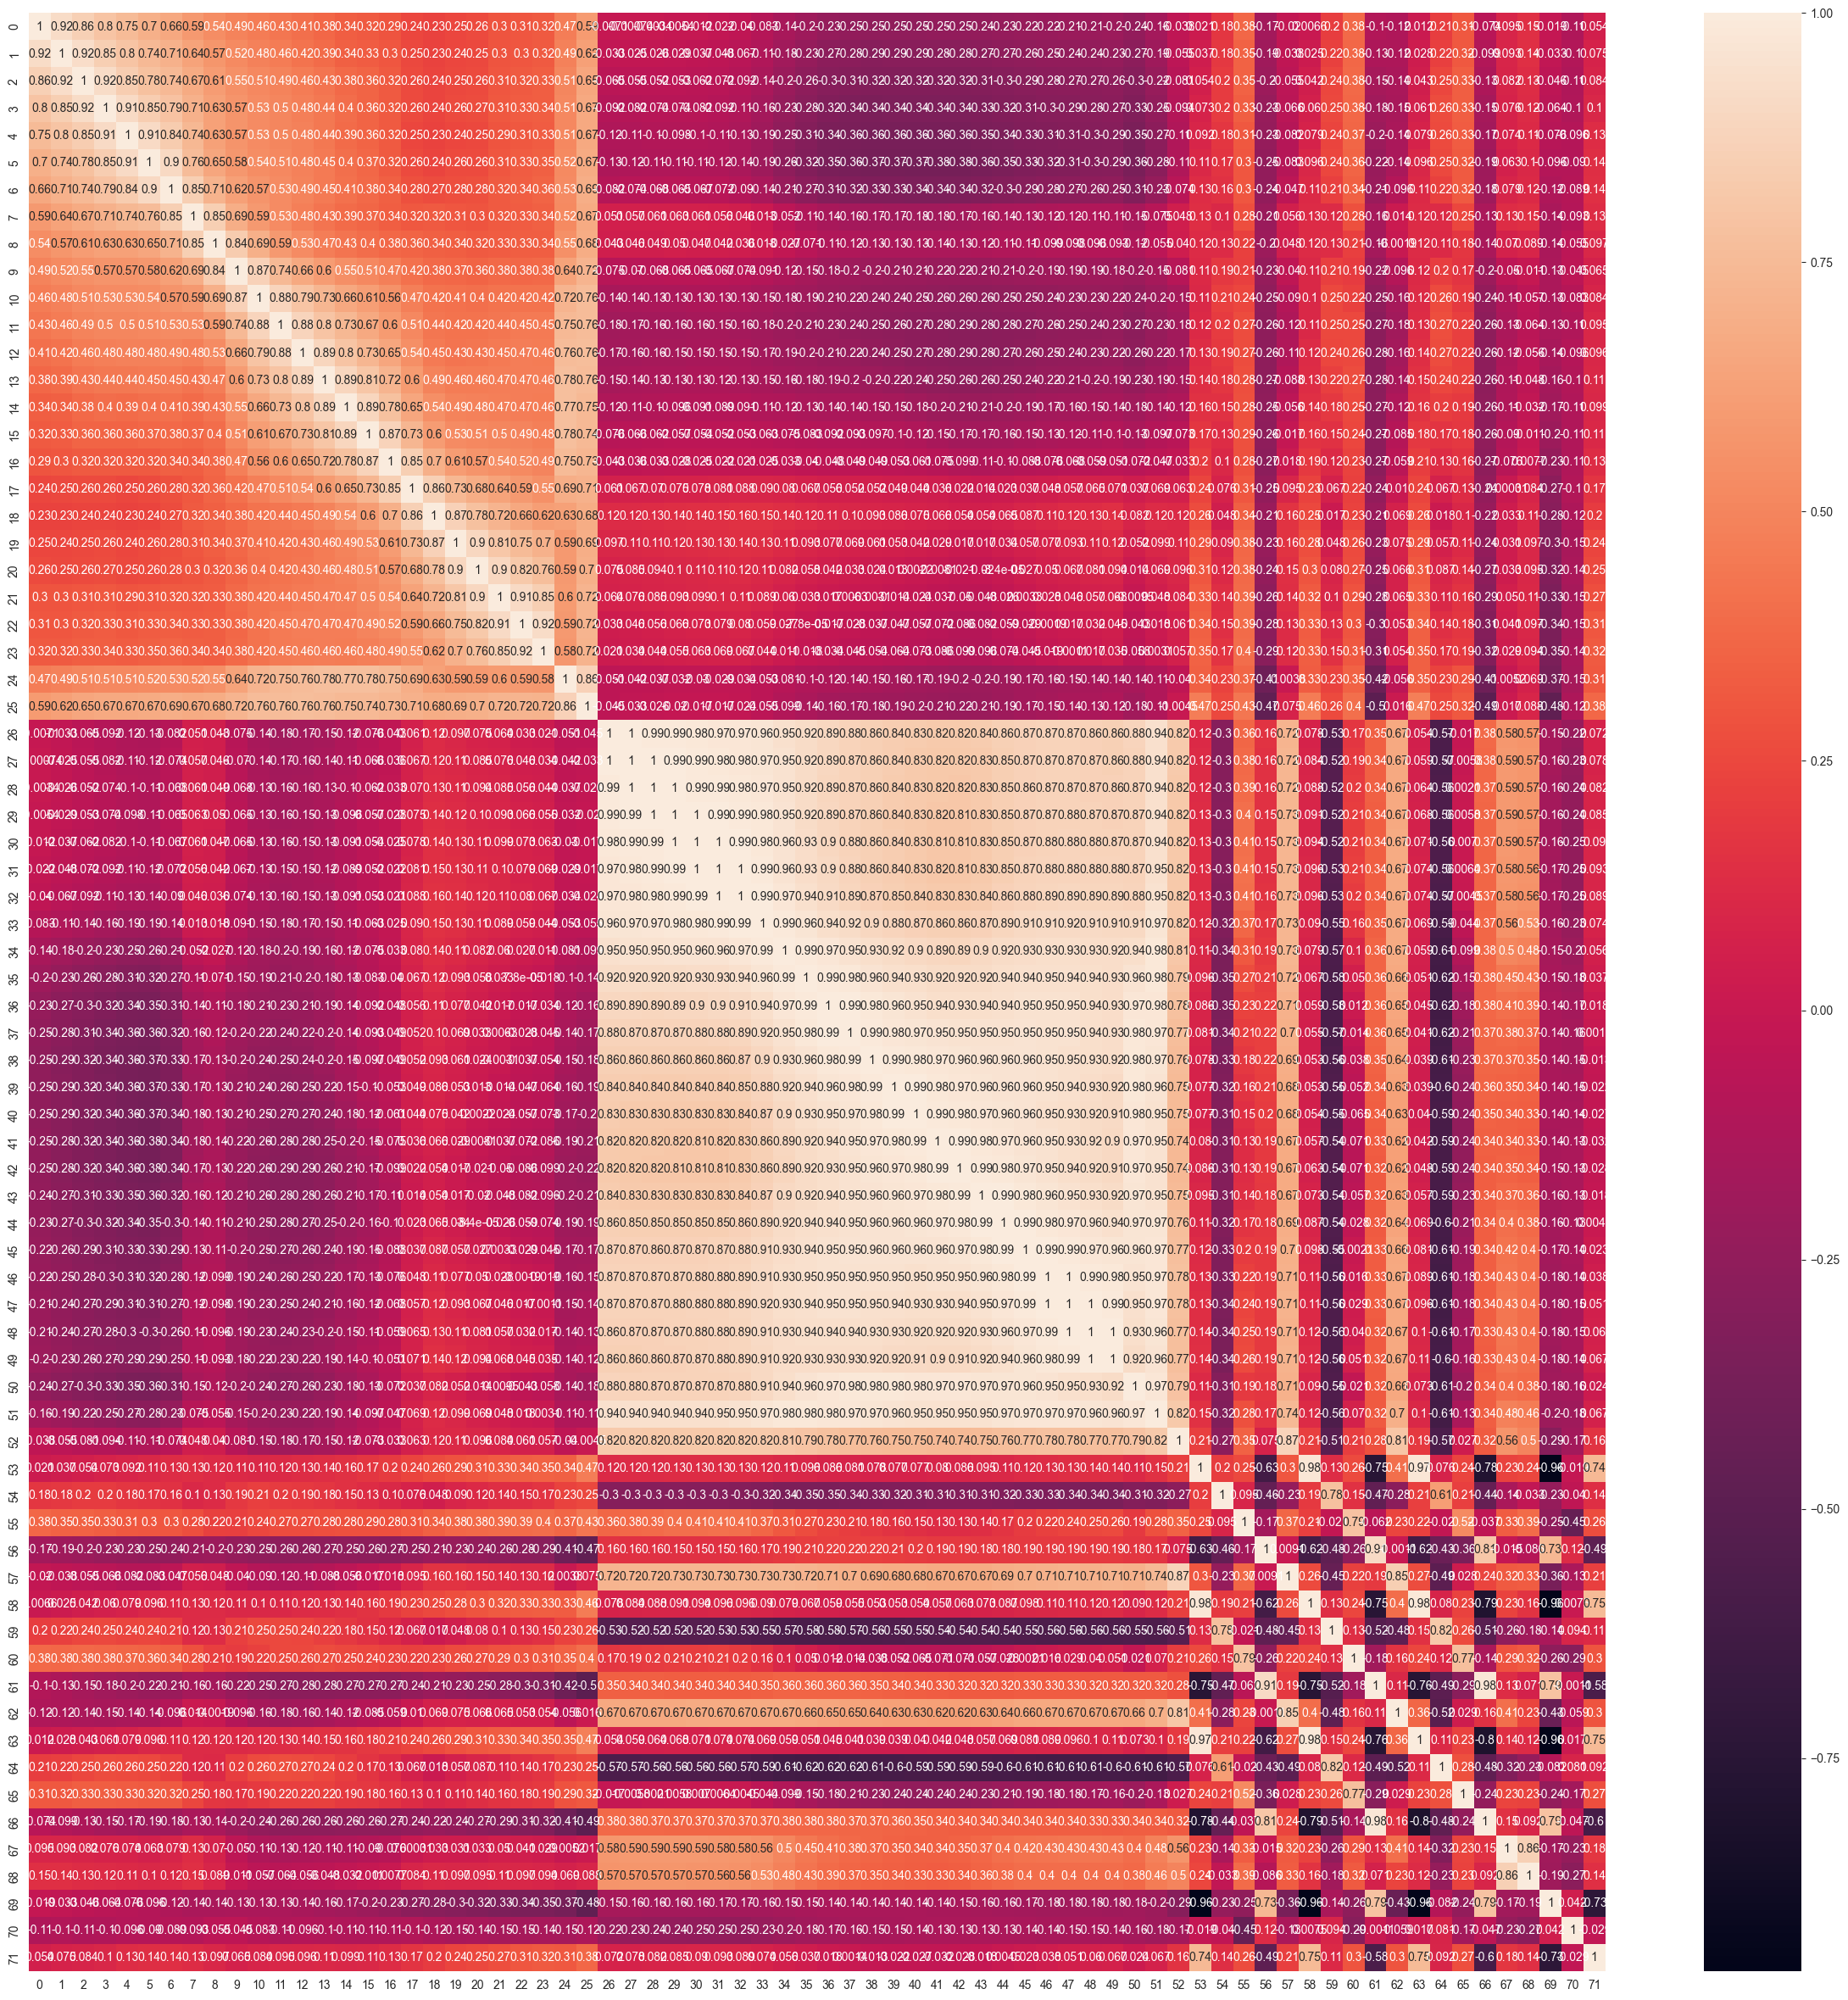

In [449]:
corr = X_data.corr()
plt.subplots(figsize=(30, 30))
sns.heatmap(corr, annot=True)

## I.2. Data UnderSampling

Utilisation de la méthode CondensedNearestNeighbour de l'Under-Sampling pour équilibrer les données dans la partie SVM.
Méthode de travail de CondensedNearestNeighbour utilise une règle du plus proche voisin pour décider itérativement si un échantillon doit être supprimé ou non. L'algorithme se déroule comme suit :
- Obtenir tous les échantillons minoritaires d'un ensemble.
- Ajouter un échantillon de la classe ciblée (classe à sous-échantillonner) dans et tous les autres échantillons de cette classe dans un ensemble.
- Parcourir l'ensemble, échantillon par échantillon, et classer chaque échantillon à l'aide d'une règle du plus proche voisin.
- Si l'échantillon est mal classé, ajoutez-le à sinon ne rien faire.
- Répéter jusqu'à ce qu'il n'y ait plus d'échantillons à ajouter.

In [450]:
undersample = CondensedNearestNeighbour(sampling_strategy='auto')
X_train_undersampled,y_train_undersampled = undersample.fit_resample(X_train,y_train)
X_train

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
925,1.10,0.60,0.50,0.80,0.80,0.80,0.20,1.00,1.30,1.50,...,-8.1,0.02,-2.76,-6.96,5865.0,-1.30,40.80,10140.0,0.0,0.00
130,2.30,2.20,2.00,3.10,2.60,1.60,2.10,3.50,3.80,3.40,...,-6.5,0.13,28.99,4.26,5825.0,4.00,35.50,10065.0,20.0,0.00
1249,2.20,1.70,0.80,3.80,4.00,4.10,2.00,1.90,1.80,2.90,...,-8.8,0.45,7.11,7.01,5865.0,34.10,48.80,10150.0,50.0,3.33
1589,0.10,0.10,0.20,0.60,0.90,1.90,2.10,2.50,3.00,3.70,...,-13.0,0.07,6.96,-3.89,5825.0,10.50,38.00,10215.0,10.0,0.00
1342,0.20,0.20,0.00,0.40,0.60,0.50,0.20,0.50,0.70,0.50,...,-6.7,0.56,6.63,-2.79,5865.0,24.45,41.35,10140.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,0.00,0.10,0.30,0.20,0.10,0.10,0.50,0.80,1.60,1.90,...,-14.1,0.05,2.31,-0.30,5800.0,9.55,45.65,10225.0,0.0,0.00
635,1.30,1.10,0.80,1.40,2.10,1.70,2.10,2.00,1.70,1.10,...,-6.8,0.86,10.11,12.18,5855.0,29.30,43.60,10120.0,15.0,0.00
1653,1.64,1.59,1.55,1.53,1.52,1.54,1.64,2.05,2.54,2.85,...,-5.9,0.81,-3.12,-0.75,5900.0,33.85,42.20,10165.0,5.0,0.00
2003,1.70,1.40,1.30,1.10,1.70,1.80,1.70,0.40,2.20,2.30,...,-7.8,0.44,-7.49,-6.10,5915.0,32.55,47.50,10190.0,-15.0,0.00


In [451]:
X_train_undersampled

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.2,0.5,0.3,0.6,0.7,1.2,0.6,1.3,2.5,3.4,...,-10.5,0.08,7.84,-8.66,5855.0,-52.70,-2.70,10260.0,50.0,0.00
1,0.4,0.4,0.6,0.5,0.1,0.7,0.3,0.5,0.7,0.4,...,-13.2,0.33,21.03,-3.71,5790.0,6.65,39.35,10245.0,-25.0,0.00
2,4.9,4.3,5.3,4.4,4.9,4.6,4.9,4.1,4.9,4.8,...,-8.0,0.29,19.46,16.25,5815.0,20.60,40.10,10155.0,35.0,0.91
3,3.1,3.8,3.6,3.5,3.7,4.2,3.7,2.5,3.8,3.7,...,-9.4,0.37,15.71,12.01,5830.0,30.30,42.80,10210.0,-30.0,1.93
4,1.0,1.4,0.6,1.1,1.7,1.6,1.5,1.8,2.7,2.6,...,-9.6,0.30,6.74,1.89,5815.0,10.51,49.45,10125.0,-10.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.2,0.1,0.4,0.4,0.5,0.7,1.3,1.4,2.1,2.4,...,-7.9,0.42,11.01,3.46,5860.0,9.90,32.30,10140.0,5.0,0.00
494,0.7,0.6,0.8,0.9,0.7,0.7,1.1,3.0,3.9,3.7,...,-6.8,0.72,-4.63,-4.01,5895.0,42.05,51.00,10120.0,25.0,0.64
495,0.4,0.4,0.3,0.5,0.5,0.8,0.8,1.1,1.3,1.4,...,-7.6,0.02,1.91,-5.84,5845.0,-20.80,23.80,10165.0,-10.0,0.00
496,0.9,0.4,0.9,0.4,0.3,0.5,0.7,0.8,0.6,0.5,...,-6.9,0.02,-6.44,0.29,5895.0,21.60,41.50,10160.0,0.0,0.00


In [452]:
# Nb de classes -1
minOne_count = np.sum(y_train_undersampled == -1)
# nb de classes 1
ones_count = np.sum(y_train_undersampled == 1)
print(f"Count of class minus one: {minOne_count}")
print(f"Count of class one: {ones_count}")

Count of class minus one: 354
Count of class one: 144


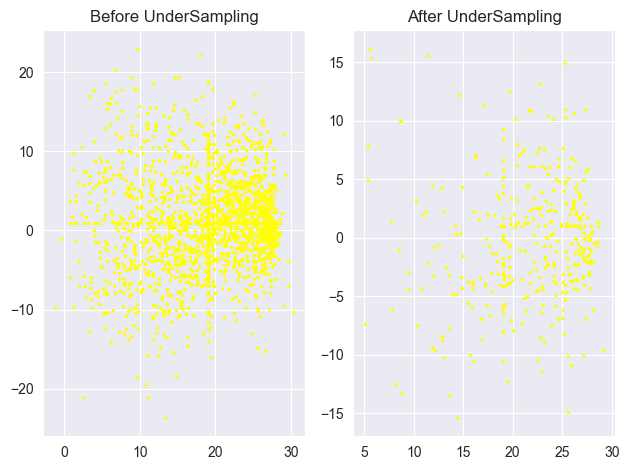

In [453]:
plt.figure()
plt.subplot(1,2,2)
plt.scatter(pd.DataFrame(X_train_undersampled).loc[y_train_undersampled == -1,49], pd.DataFrame(X_train_undersampled).loc[y_train_undersampled == -1,60],marker='o', s=2, c='yellow')
plt.title('After UnderSampling')
plt.subplot(1,2,1)
plt.scatter(pd.DataFrame(X_train).loc[y_train == -1,49], pd.DataFrame(X_train).loc[y_train == -1,60],marker='o', s=2, c='yellow')
plt.title('Before UnderSampling')
plt.tight_layout()

## I.3. Data OverSampling

Split de dataset et target utiliser pour la partie DT. car on a utilisé l'oversampling pour la partie DT.

In [454]:
data_DT = pd.read_csv('0+1dataset.data', sep=',' ,header=None).drop([72],axis=1)
target_DT = pd.read_csv('0+1dataset.data', sep=',' ,header=None).iloc[:, -1]

Utilisation de la méthode SVMSMOTE de l'oversampling pour équilibrer les données dans la partie DT.
Méthode de travail de SVMSMOTE est une extension de SMOTE qui synthétise des échantillons pour la classe minoritaire en utilisant un algorithme de suréchantillonnage basé sur SVM. L'algorithme se déroule comme suit :
- Calculer les vecteurs de support à l'aide de l'algorithme SVM.
- Choisir les vecteurs de support de la classe minoritaire.
- Trouver les k plus proches voisins des vecteurs de support de la classe minoritaire.
- Si le nombre de voisins majoritaires est inférieur à k/2, générer un nouvel échantillon par extrapolation, sinon générer un nouvel échantillon par interpolation.

In [455]:
X_train_DT,X_test_DT,y_train_DT,y_test_DT = custom_train_test_split(data_DT, target_DT,secondClass=0, random_state =2966)
X_test_DT = X_test_DT.values
y_test_DT = y_test_DT.values
oversample = SVMSMOTE(sampling_strategy=0.8,random_state=2032)
X_train_oversampled,y_train_oversampled = oversample.fit_resample(X_train_DT, y_train_DT)

In [456]:
zeroes_count = np.sum(y_train_oversampled == 0)
ones_count = np.sum(y_train_oversampled == 1)
print(f"Count of zeroes: {zeroes_count}")
print(f"Count of ones: {ones_count}")

Count of zeroes: 1899
Count of ones: 1519


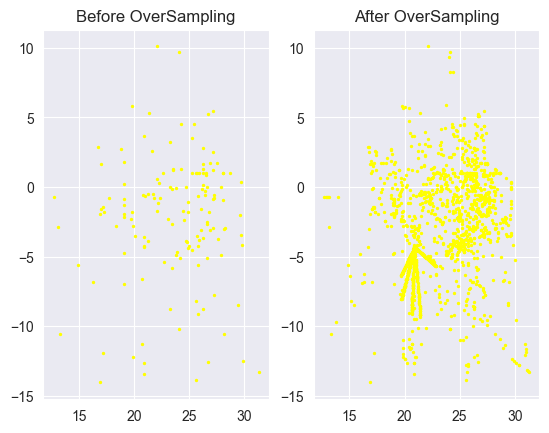

In [457]:
plt.figure()
plt.subplot(1,2,2)
plt.scatter(pd.DataFrame(X_train_oversampled).loc[np.asarray(y_train_oversampled) == 1,49], pd.DataFrame(X_train_oversampled).loc[np.asarray(y_train_oversampled) == 1,60],marker='o', s=2, c='yellow')
plt.title('After OverSampling')
plt.subplot(1,2,1)
plt.scatter(pd.DataFrame(X_train_DT).loc[np.asarray(y_train_DT) == 1,49], pd.DataFrame(X_train_DT).loc[np.asarray(y_train_DT) == 1,60],marker='o', s=2, c='yellow')
plt.title('Before OverSampling')
plt.show()

## I.4. PCA

Algorithme de PCA pour réduire la dimensionnalité du dataset, puis reconstruire la dataset à partir des dimensions réduites.
- Calculer la moyenne de chaque colonne de la matrice de données:
\begin{equation}
\text{meanVals} = \frac{1}{N}\sum_{i=1}^{N} \text{dataMat}_i
\end{equation}
- Centrer les données en soustrayant la moyenne de chaque colonne de la matrice de données:
\begin{equation}
\text{meanRemoved} = \text{dataMat} - \text{meanVals}
\end{equation}
- Calculer la matrice de covariance des données centrées:
\begin{equation}
\text{covMat} = \text{cov}(\text{meanRemoved})
\end{equation}
- Calculer les valeurs propres et les vecteurs propres de la matrice de covariance en utilisant numpy.linalg:
\begin{equation}
\text{eigVals}, \text{eigVects} = \text{eig}(\text{covMat})
\end{equation}
- Trier les valeurs propres en ordre décroissant et conserver les vecteurs propres correspondants pour prendre les k meilleurs attributs:
\begin{equation}
\text{eigValInd} = \text{argsort}(\text{eigVals})
\end{equation}

In [458]:
def pca(dataMat, topNfeat=9999999):
    meanVals = np.mean(dataMat, axis=0)
    meanRemoved = dataMat - meanVals 
    covMat = np.cov(meanRemoved, rowvar=False)
    eigVals,eigVects = np.linalg.eig(np.mat(covMat))
    eigValInd = np.argsort(eigVals) 
    eigValInd = eigValInd[:-(topNfeat+1):-1] 
    redEigVects = eigVects[:,eigValInd] 
    lowDDataMat = meanRemoved * redEigVects 
    reconMat = (lowDDataMat * redEigVects.T) + meanVals
    return lowDDataMat, reconMat

Utilisation de PCA pour réduire la dimensionnalité du dataset de 72 attributs à 7 attributs.

In [459]:
lowDMat, reconMat1 = pca(np.mat(X_train_undersampled),7)
X_test_PCA, reconMat2 = pca(np.mat(X_test),7)
pd.DataFrame(lowDMat)

,0,1,2,3,4,5,6
0,22.904390,-138.302916,-40.554996,64.222583,-1.557416,9.915465,-0.261945
1,-42.751708,-109.821544,41.336899,-4.378737,4.867937,0.322414,13.037535
2,-57.286848,-24.719395,-34.677833,2.462090,57.158140,-4.987704,-2.469652
3,-24.859399,-67.574979,40.440060,6.320528,67.688809,-3.085609,0.554486
4,-47.882638,25.973929,4.325195,-5.781505,-1.610838,-1.295164,-2.003315
...,...,...,...,...,...,...,...
493,6.067605,15.483407,-9.417761,6.398403,-2.838049,-6.763425,0.846465
494,61.288321,42.079260,-26.205433,-31.348605,-4.883197,3.373775,1.444252
495,-13.921341,-16.554025,4.877722,36.726005,-11.175514,10.879333,-4.632243
496,60.711585,2.121813,2.658774,-4.852852,-3.204394,1.760431,-8.862142


Visualisation de la datset reconstruite à partir des dimensions réduites par rapports à la dataset originale.

Text(0.5, 1.0, '7 features from the existing 72 features using PCA')

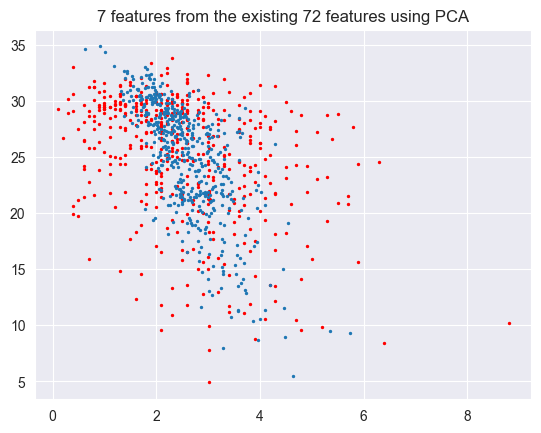

In [460]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.mat(X_train_undersampled)[:,11].flatten().A[0], np.mat(X_train_undersampled)[:,35].flatten().A[0],marker='o', s=2, c='red')
ax.scatter(reconMat1[:,11].flatten().A[0], reconMat1[:,35].flatten().A[0],marker='o', s=2)
plt.title('7 features from the existing 72 features using PCA')

# II. SVM

## II.1. From scratch implementation of SVM

### II.1.1. SVM FROM SCRATCH WITHOUT PCA

Pour résoudre ce problème d'optimisation, nous utilisons la méthode du multiplicateur de Lagrange. Nous obtenons la fonction de Lagrange :
\begin{equation}
L(\alpha) = \sum_{n=1}^N \alpha_n  - \frac{1}{2} \sum_{n=1}^N  \sum_{m=1}^N \alpha_n \alpha_m y_n y_m \phi (x_n,x_m)
\end{equation}


Pour resoudre le problème d'optimisation, on utilise cvxopt qui est une bibliothèque de Python pour l'optimisation convexe.
Il prend comme entrée la forme suivante :
\begin{equation}
\frac{1}{2} x^TPx + q^Tx
\end{equation}


La matrice P est donnée par :
\begin{equation}
P = \left[ \begin{array}{cc}
y_1 y_1 K(x_1, x_1) & \cdots & y_1 y_N K(x_1, x_N) \\
\vdots & \ddots & \vdots \\
y_N y_1 K(x_N, x_1) & \cdots & y_N y_N K(x_N, x_N) \end{array} \right]
\end{equation}

la matrice q est donnée par :
\begin{equation}
q = - \begin{bmatrix} 1 \dots  \dots 1
    \end{bmatrix}
\end{equation}

Sous les contraintes suivantes :
\begin{equation}
\alpha_n \leq C , \\ -\alpha_n \leq 0
\end{equation}


Qui est traduisez pour cvxopt par les deux matrices A, G et h:
\begin{equation}
Gx \leq h , Ax = b \\
\end{equation}
\begin{equation}
A = \begin{bmatrix} 
    y_{1} \dots &
    \dots &
    y_{N}  
    \end{bmatrix}
\end{equation}
\begin{equation}
G = \begin{bmatrix} 
    1 & 0  &\dots   & 0  \\ 
    0   &1 &\dots   & 0\\
    \vdots &\ddots  &\ddots &  \vdots  \\
     0& \dots  & 0   & 1  \\ 
     -1 & 0  &\dots   & 0  \\ 
    0   & -1 &\dots   & 0\\
    \vdots &\ddots  &\ddots &  \vdots  \\
     0& \dots  & 0   & -1  \\ 
    \end{bmatrix} _{rows = 2N,cols = N}
\end{equation}
\begin{equation}
h = \begin{bmatrix} C \\ \vdots \\ C \\ 0 \\ \vdots \\0
\end{bmatrix} _{rows =2N}
\end{equation}



La solution du problème d'optimisation est donnée par :
\begin{equation}
W = \sum_{n=1}^N \alpha_n x_n y_n
\end{equation}


On utilise les fonctions kernel pour calculer la matrice K :  
* **Noyau Linéaire** :
    \begin{equation}
    \(K(x_1, x_2) = x_1^T \cdot x_2\)
    \end{equation}
*   **Noyau Polynomial** :
    \begin{equation}
    \(K(x_1, x_2) = (x_1^T \cdot x_2 + 1)^{\gamma}\)
    \end{equation}
*   **Noyau RBF (Radial Basis Function)** :
    \begin{equation}
    \(K(x_1, x_2) = \exp \left( -\frac{{\|x_1 - x_2\|^2}}{{2 \cdot \(\text{nFeats}\) \cdot \gamma^2}} \right)\)
    \hspace{3 mm} Où \hspace{3 mm} \(\text{nFeats}\) \hspace{3 mm} \text{est le nombre d'attributs.}
    \end{equation}
*   **Noyau Sigmoïde** :
    \begin{equation}
    \(K(x_1, x_2) = \tanh(\gamma \cdot x_1^T \cdot x_2 + \gamma)\)
    \end{equation}

La valeur de biais b est calculée comme suit :
\begin{equation}
b = \frac{1}{N_{SV}} \sum_{n \in {SV}} (y_n - \sum_{m \in {SV}} \alpha_m y_m \phi (x_m,x_n))
\end{equation}


La prédiction est calculée comme suit :
\begin{equation}
y = W^T x + b
\end{equation}


In [461]:
class svm_reg :
    """ régresseur de la machine à vecteurs de support, utilise la programmation quadratique pour résoudre le vecteur de poids et biais """
    def __init__(self ,m_type='linear' ,C= 6, gamma=1):
        self.C = C
        self.gamma = gamma
        self.m_type = m_type
        self.alphas = None
        self.svs_y = None
        self.svs_x = None
        self.w = None
        self.nf = None
        self.b = None
        if m_type =='linear' :
            self.kernel = self.linear_kernal
        elif m_type == 'polynomial' :
            self.kernel = self.polynomial_kernel
        elif m_type == 'rbf' :
            self.kernel = self.rbf_kernel
        elif m_type == 'sigmoid' :
            self.kernel = self.sigmoid_kernel
        else :
            raise ValueError('Invalid kernel type')
    
    def linear_kernal (self,x1 ,x2) :
        return x1.T@x2
    
    def polynomial_kernel(self,x1, x2):
        return ( x1.T @ x2  +1) ** self.gamma
    
    def rbf_kernel(self, x1 , x2) :
        return np.exp(- np.linalg.norm(x1 -x2)**2 / (self.nf  * self.gamma**2)) 
    
    def sigmoid_kernel(self, x1, x2):
        return np.tanh(self.gamma * x1.T @ x2 + self.gamma)
        
    def fit(self,X :np.array, Y : np.array) :
        """ Initialise le modèle et calcule le vecteur de poids et b """
        n ,self.nf = X.shape

        K = np.zeros((n, n))  # Initialisation de la matrice k (modèle linéaire)
        for i in range(n):
            for j in range(n):
                K[i,j] = self.kernel(X[i] , X[j])
        
        P = matrix(np.outer(Y,Y) * K) # produit extérieur de Y et de lui-même * la matrice k

        q = matrix(-1*np.ones(n))
        b = matrix(0.0)
        A = matrix(Y*1.0,(1,n))

        g = np.diag(np.ones(n))    # première matrice diagonale (n positif 1)
        g2 = -1* np.diag(np.ones(n)) # deuxième matrice diagonale (n négatif 1)
        g = np.concatenate((g,g2),axis=0)   # combiner les deux matrices verticalement
        g = matrix(g)
        
        h = self.C * np.ones(n)     # vecteur de C
        h2 =  np.zeros(n)      # vecteur de zeros        
        h= np.concatenate((h.T,h2.T),axis = 0)  # combiner verticalement
        h = matrix(h)
        
        solution = qp(P, q, g, h, A, b)   # résoudre pour alpha
        
        alphas =  np.ravel(solution['x'])  # Récupérer les alphas et les combiner dans un tableau
        
        self.w = np.zeros(self.nf)    # calculer W
        for  alpha , y,x in zip(alphas,Y,X) :   
            self.w += alpha *y*x
    
        idxs = alphas > 1e-5
        self.svs_x = X[idxs]
        self.svs_y = Y[idxs]
        self.alphas = alphas[idxs]
        
        # Calculer b
        self.b = np.mean([self.svs_y[i] - sum([alpha * y * self.kernel(x,self.svs_x[i]) 
        for alpha , y ,x in zip(self.alphas , self.svs_y , self.svs_x )] ) for i in range(len(self.svs_x))])
        
    def _predict(self, inpt : np.array)    :
        if self.m_type == 'linear' :
            return self.w@ inpt  + self.b
        else :
            return sum([(alpha*y * self.kernel(sv_x , inpt)) for   alpha,y ,sv_x in zip(self.alphas, self.svs_y , self.svs_x) ]) +self.b
        
    
    def predict(self, inpt : np.array) :
        """ prend un vecteur d'entrée et calcule le résultat scalaire attendu """
        inpt = np.array(inpt)
        if len(inpt.shape ) == 1 :
            return self._predict(inpt)
        else :
            res = np.zeros(len(inpt)) 
            for i in range(len(inpt)) :
                res[i] = self._predict(inpt[i])
            return res

On utilise One vs all classifier pour résoudre le problème de classification on appelant la classe svm_reg pour chaque classe dans le dataset.
la méthode fit() de la classe svm_reg utilise la méthode fit() de la classe svm_reg pour determiner les vecteur de supports et ensuite, determiner les poids et biais de chaque classe, puis il transforme le problème de regression en un problème de classification.


In [462]:
class svm_class :
    """ One vs all classifier , utilise un ensemble de modèles svm_reg pour chaque classe dans la sortie. """
    def __init__(self, m_type='linear' ,C=6 ,gamma=1):
        self.models_dict = {}
        self.C = C
        self.gamma = gamma
        self.m_type = m_type
    
    def fit(self, X , Y) :
        classes = set(Y)
        models_dict = dict.fromkeys(classes)
        for cl in classes :
            idxs = (Y== cl)
            Y_modified =-1* np.ones(len(Y))
            Y_modified[idxs] = 1
            models_dict[cl] = svm_reg(m_type= self.m_type ,C = self.C , gamma= self.gamma)
            models_dict[cl].fit(X,Y_modified.T)

        self.models_dict = models_dict

    def _predict(self,inpt) :
        results_dict = dict.fromkeys(self.models_dict.keys())
        for cl in self.models_dict.keys() :
            results_dict[cl] = self.models_dict[cl].predict(inpt)
        
        return max(results_dict, key=results_dict.get)

    def predict(self,inpt) :
        inpt = np.array(inpt)
        if len(inpt.shape ) == 1 :
            self._predict(inpt)
        else :
            res = np.zeros(len(inpt)) 
            for i in range(len(inpt)) :
                res[i] = self._predict(inpt[i])
            return res

On crée un objet de la classe svm_class et on l'entraine sur les données de training undersampled pour la partie SVM.
On choisi les paramètres C=13 et gamma=7 de la fonction kernel RBF.

In [463]:
model = svm_class(m_type='rbf',C=13,gamma=7)
x = np.array(X_train_undersampled)
y = np.array(y_train_undersampled)
model.fit(x,y)

     pcost       dcost       gap    pres   dres
 0:  1.2649e+02 -4.5897e+04  7e+04  3e-01  3e-14
 1: -3.3724e+02 -7.3519e+03  7e+03  2e-02  3e-14
 2: -9.9579e+02 -3.1950e+03  2e+03  4e-03  3e-14
 3: -1.2797e+03 -2.0721e+03  8e+02  1e-03  3e-14
 4: -1.4195e+03 -1.5837e+03  2e+02  1e-04  4e-14
 5: -1.4575e+03 -1.4824e+03  2e+01  1e-05  4e-14
 6: -1.4640e+03 -1.4659e+03  2e+00  5e-07  4e-14
 7: -1.4646e+03 -1.4647e+03  8e-02  1e-08  4e-14
 8: -1.4647e+03 -1.4647e+03  3e-03  2e-10  4e-14
 9: -1.4647e+03 -1.4647e+03  1e-04  2e-12  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2649e+02 -4.5897e+04  7e+04  3e-01  3e-14
 1: -3.3724e+02 -7.3519e+03  7e+03  2e-02  3e-14
 2: -9.9579e+02 -3.1950e+03  2e+03  4e-03  3e-14
 3: -1.2797e+03 -2.0721e+03  8e+02  1e-03  3e-14
 4: -1.4195e+03 -1.5837e+03  2e+02  1e-04  4e-14
 5: -1.4575e+03 -1.4824e+03  2e+01  1e-05  4e-14
 6: -1.4640e+03 -1.4659e+03  2e+00  5e-07  4e-14
 7: -1.4646e+03 -1.4647e+03  8e-02  1e-08  4e-1

In [464]:
support_vectorsc0 = None
support_vectorsc1 = None
for class_label, svm_model in model.models_dict.items():
    support_vectorsc0 = svm_model.svs_x[svm_model.svs_y == -1]
    support_vectorsc1 = svm_model.svs_x[svm_model.svs_y == 1]
print(f"Class 0 number of support vectors: {len(support_vectorsc0)}")
print(f"Class 1 number of support vectors: {len(support_vectorsc1)}")

Class 0 number of support vectors: 125
Class 1 number of support vectors: 217


On prédit les valeurs de la dataset de test, on appellant la méthode predict() de la classe svm_class.

In [465]:
res_model = model.predict(np.array(X_test))
print('Model test accuracy =' , round(accuracy_score(y_test,res_model) *100,2),'%')

Model test accuracy = 91.65 %


In [466]:
confusion_matrix(y_test,res_model) # matrice de confusion pour la dataset de test

array([[439,  36],
       [  5,  11]], dtype=int64)

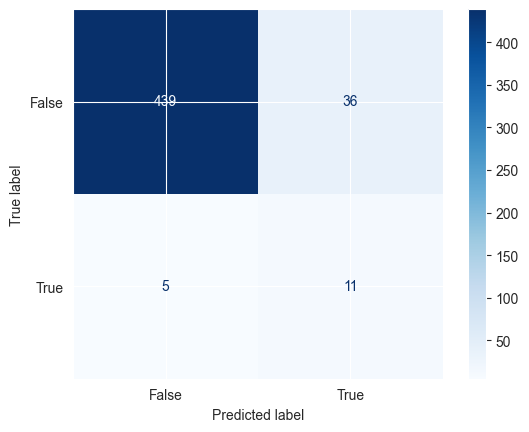

In [467]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=res_model, display_labels=["False", "True"], cmap='Blues')
plt.show()

In [468]:
print("Test: \n",classification_report(y_test,res_model))

Test: 
               precision    recall  f1-score   support

        -1.0       0.99      0.92      0.96       475
         1.0       0.23      0.69      0.35        16

    accuracy                           0.92       491
   macro avg       0.61      0.81      0.65       491
weighted avg       0.96      0.92      0.94       491


##### Courbe ROC
Visualisation du courbe ROC pour mieux évaluer le modèle en relation avec le taux de faux positif et le taux de vrai positif.

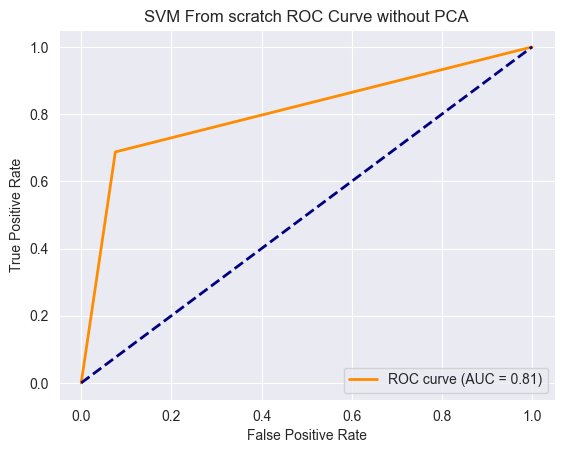

In [469]:
# Calculet FP ratio, TP ratio
fpr, tpr, thresholds = roc_curve(y_test, res_model)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM From scratch ROC Curve without PCA')
plt.legend(loc='lower right')
plt.show()

### II.1.2. SVM FROM SCRATCH WITH PCA

On crée un objet de la classe svm_class et on l'entraine sur les données de training undersampled et en reduisant la dimensionnalité du dataset par PCA de 72 attributs à 7 attributs.

In [470]:
model_PCA = svm_class(m_type='rbf',C=13,gamma=7)
x_PCA = np.array(lowDMat)
y_PCA = np.array(y_train_undersampled)
model_PCA.fit(x_PCA,y_PCA)

     pcost       dcost       gap    pres   dres
 0:  1.8179e+03 -2.4844e+04  3e+04  3e-17  6e-15
 1:  3.5445e+02 -3.4012e+03  4e+03  2e-13  3e-15
 2: -3.1553e+02 -9.1432e+02  6e+02  6e-15  2e-15
 3: -3.9732e+02 -4.7224e+02  7e+01  7e-14  1e-15
 4: -4.0309e+02 -4.0795e+02  5e+00  2e-13  1e-15
 5: -4.0350e+02 -4.0368e+02  2e-01  6e-14  2e-15
 6: -4.0354e+02 -4.0355e+02  6e-03  1e-13  2e-15
 7: -4.0355e+02 -4.0355e+02  2e-04  2e-13  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.8179e+03 -2.4844e+04  3e+04  3e-17  6e-15
 1:  3.5445e+02 -3.4012e+03  4e+03  2e-13  3e-15
 2: -3.1553e+02 -9.1432e+02  6e+02  6e-15  2e-15
 3: -3.9732e+02 -4.7224e+02  7e+01  7e-14  1e-15
 4: -4.0309e+02 -4.0795e+02  5e+00  2e-13  1e-15
 5: -4.0350e+02 -4.0368e+02  2e-01  6e-14  2e-15
 6: -4.0354e+02 -4.0355e+02  6e-03  1e-13  2e-15
 7: -4.0355e+02 -4.0355e+02  2e-04  2e-13  2e-15
Optimal solution found.


In [471]:
res_model_PCA = model_PCA.predict(np.array(X_test_PCA))
print('Model test accuracy =' , round(accuracy_score(y_test,res_model_PCA) *100,2),'%')

Model test accuracy = 95.11 %


In [472]:
confusion_matrix(y_test,res_model_PCA)

array([[467,   8],
       [ 16,   0]], dtype=int64)

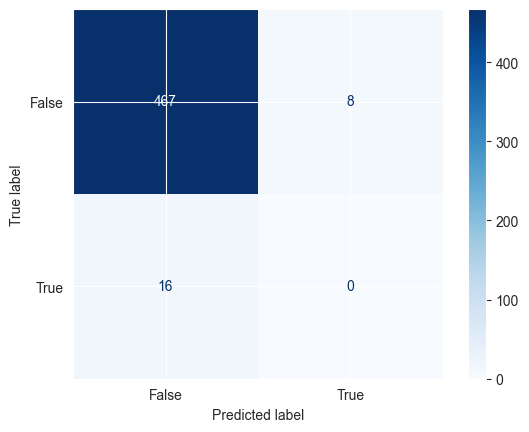

In [473]:
disp_PCA = ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=res_model_PCA, display_labels=["False", "True"], cmap='Blues')
plt.show()

In [474]:
print("Test: \n",classification_report(y_test,res_model_PCA))

Test: 
               precision    recall  f1-score   support

        -1.0       0.97      0.98      0.97       475
         1.0       0.00      0.00      0.00        16

    accuracy                           0.95       491
   macro avg       0.48      0.49      0.49       491
weighted avg       0.94      0.95      0.94       491


Visualisation du courbe ROC de SVM from scratch avec PCA pour mieux évaluer le modèle en relation avec le taux de faux positif et le taux de vrai positif.

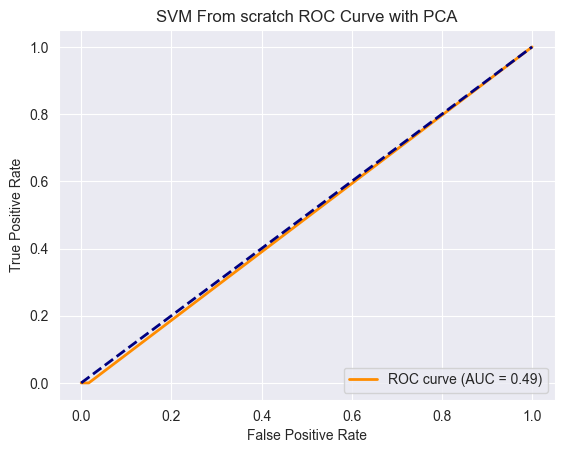

In [475]:
# Calculet FP ratio, TP ratio
fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(y_test, res_model_PCA)
roc_auc_PCA = auc(fpr_PCA, tpr_PCA)

plt.figure()
plt.plot(fpr_PCA, tpr_PCA, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_PCA)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM From scratch ROC Curve with PCA')
plt.legend(loc='lower right')
plt.show()

## II.2. Sci-kit learn implementation of SVM

### II.2.1. SVM FROM SCI-KIT LEARN WITHOUT PCA

On crée un objet de la classe SVC de sci-kit learn et on l'entraine sur les données de training undersampled.
On faits appel à la méthode predict() de la classe SVC pour prédire les valeurs de la dataset de test.

In [476]:
svm = SVC(kernel="rbf",gamma=7,C=13,probability=True)
svm.fit(X_train_undersampled,y_train_undersampled)
y_pred = svm.predict(X_test)
# Accuracy
print("Test Accuracy of the model without using PCA: ",round(accuracy_score(y_test,y_pred)*100,2),"%")

Test Accuracy of the model without using PCA:  96.74 %


In [477]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.97      1.00      0.98       475
         1.0       0.00      0.00      0.00        16

    accuracy                           0.97       491
   macro avg       0.48      0.50      0.49       491
weighted avg       0.94      0.97      0.95       491


C:\Users\ah-ma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ah-ma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ah-ma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [478]:
confusion_matrix(y_test,y_pred)

array([[475,   0],
       [ 16,   0]], dtype=int64)

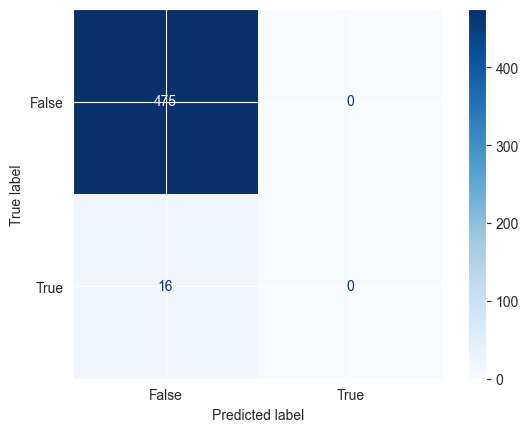

In [479]:
disp_sk = ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=["False", "True"], cmap='Blues')
plt.show()

##### Courbe ROC
Visualisation du courbe ROC de SVM de sci-kit-learn sans PCA pour mieux évaluer le modèle en relation avec le taux de faux positif et le taux de vrai positif.

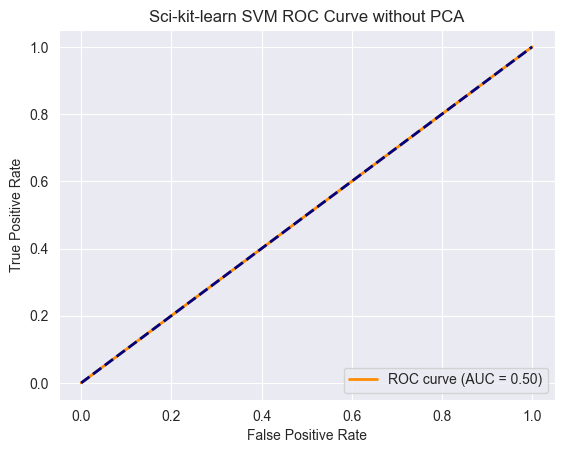

In [480]:
# Calculer FP ratio, TP ratio
fpr_sk, tpr_sk, thresholds_sk = roc_curve(y_test, y_pred)
roc_auc_sk = auc(fpr_sk, tpr_sk)

plt.figure()
plt.plot(fpr_sk, tpr_sk, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_sk)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sci-kit-learn SVM ROC Curve without PCA')
plt.legend(loc='lower right')
plt.show()

### II.2.2. SVM FROM SCI-KIT LEARN WITH PCA

On crée un objet de la classe SVC de sci-kit learn et on l'entraine sur les données de training undersampled et en reduisant la dimensionnalité du dataset par PCA de 72 attributs à 7 attributs.

In [481]:
svm_PCA = SVC(kernel="rbf",gamma=7,C=13,probability=True)
svm_PCA.fit(x_PCA,y_PCA)

SVC(C=13, gamma=7, probability=True)

In [482]:
y_pred_PCA = svm_PCA.predict(np.array(X_test_PCA))
y_pred_train_PCA = svm_PCA.predict(x_PCA)
# Accuracy
print("Test Accuracy of the model with PCA: ",round(accuracy_score(y_test,y_pred_PCA)*100,2),"%")

Test Accuracy of the model with PCA:  96.74 %


In [483]:
confusion_matrix(y_test,y_pred_PCA)

array([[475,   0],
       [ 16,   0]], dtype=int64)

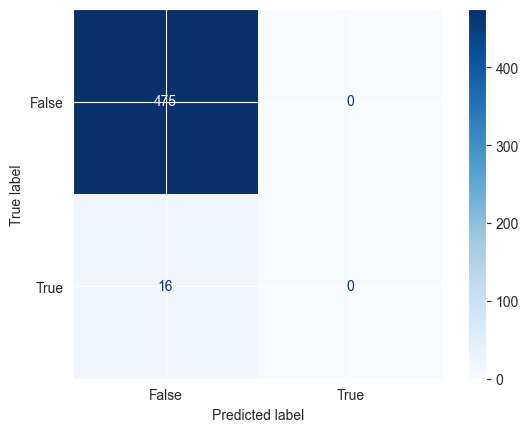

In [484]:
disp_sk_PCA = ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred_PCA, display_labels=["False", "True"], cmap='Blues')
plt.show()

##### Courbe ROC
Visualisation du courbe ROC de SVM de sci-kit-learn avec PCA pour mieux évaluer le modèle en relation avec le taux de faux positif et le taux de vrai positif.

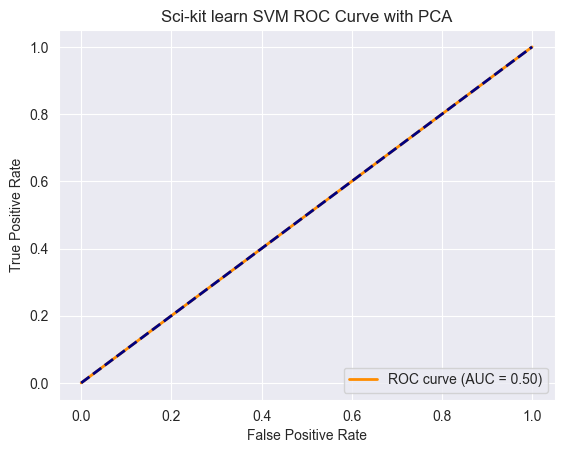

In [485]:
# Calculer FP ratio, TP ratio
fpr_sk_PCA, tpr_sk_PCA, thresholds_sk_PCA = roc_curve(y_test, y_pred_PCA)
roc_auc_sk_PCA = auc(fpr_sk_PCA, tpr_sk_PCA)

plt.figure()
plt.plot(fpr_sk_PCA, tpr_sk_PCA, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_sk_PCA)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sci-kit learn SVM ROC Curve with PCA')
plt.legend(loc='lower right')
plt.show()

# III. DECISION TREE

## III.1. From scratch implementation of CART DT

On crée une classe TreeNode pour representer les nœuds de l'arbre de decision.


In [486]:
class TreeNode:
    def __init__(self, gini_impurity, num_samples, predicted_class=None, split_feature=None, split_value=None, left=None, right=None):
        self.gini_impurity = gini_impurity
        self.num_samples = num_samples
        self.predicted_class = predicted_class
        self.split_feature = split_feature
        self.split_value = split_value
        self.left = left
        self.right = right

On utilise l'indice de Gini qui est utlisé dans l'algorithme de CART DT pour calculer l'impureté de Gini d'un dataset pour déterminer le meilleur split.
L'équation de l'indice de Gini est donnée par :
\begin{equation}
\text{Gini} = 1 - \sum_{i=1}^{K} p_i^2
\end{equation}
\begin{equation} \text{ Où } p_i \text{ représente la probabilité d'apparition de la classe i dans l'ensemble de données.} \end{equation}

In [487]:
def calculate_gini_impurity(y_values):
    total_samples = len(y_values)
    class_counts = np.bincount(y_values.astype(int))
    probabilities = class_counts / total_samples
    gini_impurity = 1 - np.sum(probabilities**2)
    return gini_impurity

On utilise la méthode find_best_split() pour trouver le meilleur split pour un dataset, qui faits appel à la méthode calculate_gini_impurity() pour calculer l'impureté de Gini de chaque split.
L'algorithme de la méthode find_best_split() se base sur la recherche exhaustive pour trouver le meilleur split, suivant les étapes suivantes :
- Parcours de chaque caractéristique pour déterminer la meilleure division.
- Pour chaque caractéristique, explore les valeurs uniques, divise les données et calcule l'impureté de Gini pour chaque division.
- Sélectionne la division qui minimise l'impureté pondérée basée sur la taille des sous-ensembles.
- Retourne la caractéristique et la valeur de division qui offrent la division la plus pure selon l'impureté de Gini.

In [488]:
def find_best_split(X, y):
    m, n = X.shape

    best_gini = float('inf')
    best_feature = None
    best_split_value = None

    for feature in range(n):
        unique_values = np.unique(X[:, feature])
        for split_value in unique_values:
            left_indices = X[:, feature] <= split_value
            right_indices = ~left_indices

            left_gini = calculate_gini_impurity(y[left_indices])
            right_gini = calculate_gini_impurity(y[right_indices])

            weighted_gini = (len(y[left_indices]) / m) * left_gini + (len(y[right_indices]) / m) * right_gini

            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_feature = feature
                best_split_value = split_value

    return best_feature, best_split_value

X_train_DT = X_train.values #pour transformer les donner du X_train en matrice
y_train_DT = y_train.values

On utilise la méthode build_DT() pour construire l'arbre de decision, qui faits appel à la méthode find_best_split() pour trouver le meilleur split.
L'algorithme de la méthode build_DT() se base sur la récursivité pour construire l'arbre de decision, suivant les étapes suivantes :
- Si les conditions d'arrêt sont remplies, créer un nœud feuille.
- Trouver le meilleur split.
- Si aucun split n'est trouvé, créer un nœud feuille.
- Diviser les données en fonction du meilleur split.
- Construire récursivement les sous-arbres gauche et droit.
- Retourner le nœud racine.

In [489]:
def build_DT(X, y, max_depth=None, min_samples_leaf=1):
    # Condition de stop : si profondeur max atteinte, une seule classe restante, ou seuil minimal de données atteint
    if max_depth == 0 or len(np.unique(y)) == 1 or len(y) < min_samples_leaf:
        # Prédiction de classe basée sur la classe majoritaire dans les données actuelles
        predicted_class = np.argmax(np.bincount(y))
        return TreeNode(
            gini_impurity=calculate_gini_impurity(y),
            num_samples=len(y),
            predicted_class=predicted_class
        )

    # Trouve la meilleure caractéristique et valeur de division pour l'arbre de décision
    best_feature, best_split_value = find_best_split(X, y)

    # Si aucune meilleure caractéristique n'est trouvée, retourne la prédiction basée sur la classe majoritaire
    if best_feature is None:
        predicted_class = np.argmax(np.bincount(y))
        return TreeNode(
            gini_impurity=calculate_gini_impurity(y),
            num_samples=len(y),
            predicted_class=predicted_class
        )

    # Divise les données en sous-ensembles gauche et droit en fonction de la meilleure caractéristique et valeur de division
    left_indices = X[:, best_feature] <= best_split_value
    right_indices = ~left_indices

    # Construit les sous-arbres récursivement pour les sous-ensembles gauche et droit
    left_subtree = build_DT(X[left_indices, :], y[left_indices], max_depth=max_depth - 1, min_samples_leaf=min_samples_leaf)
    right_subtree = build_DT(X[right_indices, :], y[right_indices], max_depth=max_depth - 1, min_samples_leaf=min_samples_leaf)

    # Retourne un nœud de l'arbre de décision avec les informations sur la division
    return TreeNode(
        gini_impurity=calculate_gini_impurity(y),
        num_samples=len(y),
        split_feature=best_feature,
        split_value=best_split_value,
        left=left_subtree,
        right=right_subtree
    )

On utilise la méthode predict() pour prédire les valeurs de la dataset de test.
L'algorithme de la méthode predict() se base sur la récursivité pour prédire les valeurs de la dataset de test, suivant les étapes suivantes :
- Si le noeud est une feuille, retourner la classe prédite.
- Si la valeur de la caractéristique de l'instance est inférieure ou égale à la valeur de division du noeud, descendre dans le sous-arbre gauche.
- Sinon, descendre dans le sous-arbre droit.
- Retourner la classe prédite.

In [490]:
def predict(tree, instance):
    if tree.predicted_class is not None:
        return tree.predicted_class
    if instance[tree.split_feature] <= tree.split_value:
        return predict(tree.left, instance)
    else:
        return predict(tree.right, instance)

On utilise la méthode tree_to_dot() qui utilise la bibliothèque graphviz pour convertir l'arbre de decision en format PNG pour pouvoir le visualiser.
L'algorithme de la méthode tree_to_dot() se base sur la récursivité pour convertir l'arbre de decision en format PNG, suivant les étapes suivantes :
- Si le noeud est une feuille, retourner la classe prédite.
- Si la valeur de la caractéristique de l'instance est inférieure ou égale à la valeur de division du noeud, descendre dans le sous-arbre gauche.
- Sinon, descendre dans le sous-arbre droit.
- Retourner la classe prédite.

In [491]:
def tree_to_dot(node, dot, feature_names, class_names=None, parent_name=None, edge_label=None):
    if node is not None:
        current_name = str(id(node))
        if parent_name is not None:
            dot.edge(parent_name, current_name, label=edge_label)
        if node.predicted_class is not None:
            class_label = f"Class: {class_names[node.predicted_class]}" if class_names else f"Class: {node.predicted_class}"
            dot.node(current_name, label=class_label, shape="box", color="darkgreen")
        else:
            feature_label = f"Feature: {feature_names[node.split_feature]}\nSplit Value: {node.split_value:.2f}"
            dot.node(current_name, label=feature_label, shape="box", color="blue")
            tree_to_dot(node.left, dot, feature_names, class_names, current_name, "True")
            tree_to_dot(node.right, dot, feature_names, class_names, current_name, "False")

Faire appel à la méthode build_DT() pour construire l'arbre de decision, en spécifiant la profondeur maximale de l'arbre et le nombre minimum d'échantillons dans les feuilles.

In [492]:
# Convertir y_train en tableau d'entiers
X_train_oversampled = X_train_oversampled.values.astype(int)
y_train_oversampled = y_train_oversampled.values.astype(int)

FS_CART_DT = build_DT(X_train_oversampled, y_train_oversampled, max_depth=5, min_samples_leaf=5)

Prédire les valeurs de la dataset de test en faisant appel à la méthode predict().

In [493]:
# Enregister les predictions pour test data
y_pred_DT = [predict(FS_CART_DT, sample) for sample in X_test_DT]
print(classification_report(y_test_DT, y_pred_DT))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       475
         1.0       0.20      0.62      0.30        16

    accuracy                           0.91       491
   macro avg       0.59      0.77      0.63       491
weighted avg       0.96      0.91      0.93       491


In [494]:
# Calcul accuracy
accuracy = np.sum(y_test_DT == y_pred_DT) / len(y_test_DT)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 90.63%


In [495]:
confusion_matrix(y_test_DT,y_pred_DT)

array([[435,  40],
       [  6,  10]], dtype=int64)

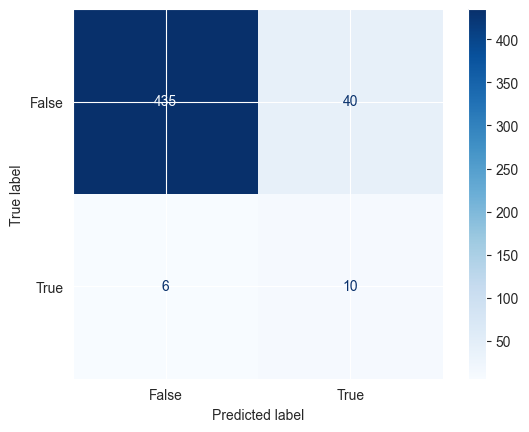

In [496]:
disp_DT = ConfusionMatrixDisplay.from_predictions(y_true=y_test_DT, y_pred=y_pred_DT, display_labels=["False", "True"], cmap='Blues')
plt.show()

Visualiser l'arbre de decision en faisant appel à la méthode tree_to_dot().

In [497]:
featNames = ["WSR0","WSR1","WSR2","WSR3","WSR4","WSR5","WSR6","WSR7","WSR8","WSR9","WSR10","WSR11","WSR12","WSR13","WSR14","WSR15","WSR16","WSR17","WSR18","WSR19","WSR20","WSR21","WSR22","WSR23","WSR_PK","WSR_AV","T0","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17","T18","T19","T20","T21","T22","T23","T_PK","T_AV","T85","RH85","U85","V85","HT85","T70","RH70","U70","V70","HT70","T50","RH50","U50","V50","HT50","KI","TT","SLP","SLP_","Precp"]
dot = Digraph(comment='Ozone Cart Decision Tree')
tree_to_dot(FS_CART_DT, dot, featNames, ["0", "1"])
dot.render('Ozone_CART_DT', format='png', cleanup=True)

'Ozone_CART_DT.png'

##### Courbe ROC
Visualisation du courbe ROC de from scratch implementation de CART DT pour mieux évaluer le modèle en relation avec le taux de faux positif et le taux de vrai positif.

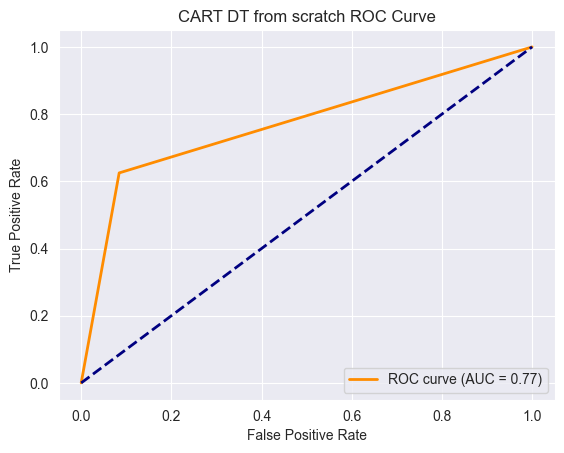

In [498]:
# Calculer FP ratio, TP ratio
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_test_DT, y_pred_DT)
roc_auc = auc(fpr_DT, tpr_DT)

plt.figure()
plt.plot(fpr_DT, tpr_DT, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CART DT from scratch ROC Curve')
plt.legend(loc='lower right')
plt.show()

## III.2. Sci-kit learn implementation of CART DT

On crée un objet de la classe DecisionTreeClassifier de sci-kit learn et on l'entraine sur les données de training oversampled.

In [499]:
CART_DT = DecisionTreeClassifier(random_state=1706)
CART_DT.fit(X_train_oversampled, y_train_oversampled)

DecisionTreeClassifier(random_state=1706)

Prédire les valeurs de la dataset de test en faisant appel à la méthode predict() de sklearn.

In [500]:
y_pred_sk_DT = CART_DT.predict(X_test_DT)
accuracy = np.sum(y_test_DT == y_pred_sk_DT) / len(y_test_DT)
print(f"Accuracy: {accuracy * 100:.2f}%")
confusion_matrix(y_test_DT,y_pred_sk_DT)

Accuracy: 91.45%


array([[441,  34],
       [  8,   8]], dtype=int64)

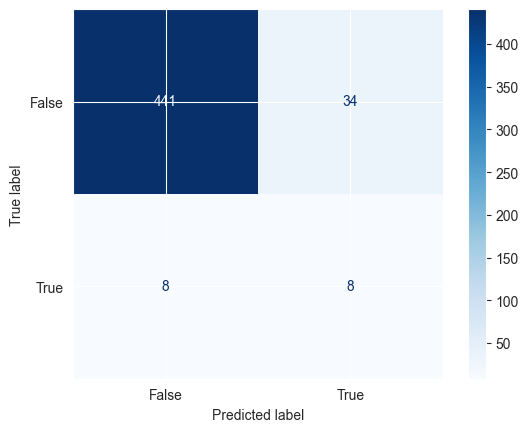

In [501]:
disp_sk_DT = ConfusionMatrixDisplay.from_predictions(y_true=y_test_DT, y_pred=y_pred_sk_DT, display_labels=["False", "True"], cmap='Blues')
plt.show()

In [502]:
print(classification_report(y_test_DT, y_pred_sk_DT))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95       475
         1.0       0.19      0.50      0.28        16

    accuracy                           0.91       491
   macro avg       0.59      0.71      0.62       491
weighted avg       0.96      0.91      0.93       491


##### Courbe ROC
Visualisation du courbe ROC de sci-kit learn implementation de CART DT pour mieux évaluer le modèle en relation avec le taux de faux positif et le taux de vrai positif.

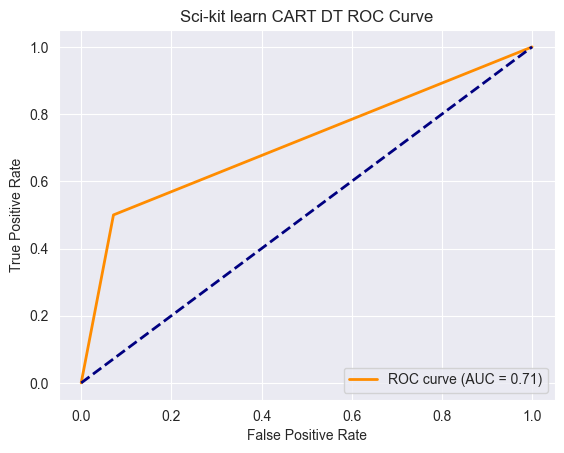

In [503]:
# Calculer FP ratio, TP ratio
fpr_sk_DT, tpr_sk_DT, thresholds_sk_DT = roc_curve(y_test_DT, y_pred_sk_DT)
roc_auc = auc(fpr_sk_DT, tpr_sk_DT)

plt.figure()
plt.plot(fpr_sk_DT, tpr_sk_DT, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sci-kit learn CART DT ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Webographie

- Zhang, K., Fan, W., & Yuan, X. (2008). Ozone Level Detection. UCI Machine Learning Repository. https://doi.org/https://doi.org/10.24432/C5NG6W
- Under-sampling — version 0.11.0. (n.d.). https://imbalanced-learn.org/stable/under_sampling.html#condensed-nearest-neighbors
- Over-sampling — version 0.11.0. (n.d.). https://imbalanced-learn.org/stable/over_sampling.html
- The flowchart of the SVM-SMOTE algorithm. (n.d.-b). ResearchGate. https://www.researchgate.net/figure/The-flowchart-of-the-SVM-SMOTE-algorithm_fig3_358509219
- EzzatEsam. (n.d.). EzzatEsam/SVM-Implementation-Python-QuadraticProgramming. GitHub. https://github.com/EzzatEsam/SVM-Implementation-Python-QuadraticProgramming/blob/master/svm_quad.ipynb
- Meng, Z. (2019). Ground ozone level prediction using machine learning. Journal of Software Engineering and Applications, 12(10), 423–431. https://doi.org/10.4236/jsea.2019.1210026
- Rocklen. (2021, April 19). Ozone level detection. Kaggle. https://www.kaggle.com/code/rocklen/ozone-level-detection
